## Gradient Bandits
- action의 선호도 $H_t(a)$를 학습 => 더 높은 선호도의 action을 더 자주 선택하도록 (reward와는 다름)
- 선호도는 softmax 함수를 통해 계산됨
  
    $Pr(A_t=a)=\frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(a)}}=\pi_t(a)$
    - $\pi_t(a)$: time $t$에 action $a$를 선택할 확률
  
- 모든 action에 대해 선호도 $H_0(a)=0$ 로 초기화
- gradient bandits 알고리즘은 보상의 평균값을 업데이트하지 않고, SGD(stochastic gradient ascent)를 통해 각 action의 선호도 $H_t(a)$를 업데이트한다
- 각 action이 취해질 때마다, action의 확률 $\pi$와 learning rate에 의해 가중치가 부여된 reward가 반환된다 => 새로운 $H_t(A_t)$

$H_{t+1}(A_t)=H_t(A_t) + \alpha(R_t-\overline R_t)(1-\pi_t(A_t))$


$H_{t+1}(a)=H_t(a)-\alpha(R_t-\overline R_t)\pi_t(a)$

[*Code Reference](https://www.datahubbs.com/multi-armed-bandits-reinforcement-learning-2/)

In [15]:
class grad_bandit:

    def __init__(self, k, alpha, iters, mu='random'):
        # Number of arms
        self.k = k
        self.actions = np.arange(k)
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 1
        # Step count for each arm
        self.k_n = np.ones(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)
        # Initialize preferences
        self.H = np.zeros(k)
        # Learning rate
        self.alpha = alpha

        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages            
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)
            
    # softmax 변형: 각 요소에 max() 값을 뺌
    def softmax(self):
        self.prob_action = np.exp(self.H - np.max(self.H)) \
            / np.sum(np.exp(self.H - np.max(self.H)), axis=0)
    
    def pull(self):
        # Update probabilities
        self.softmax()
        # Select highest preference action
        a = np.random.choice(self.actions, p=self.prob_action)

        reward = np.random.normal(self.mu[a], 1)
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1

        # Update total
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n

        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (reward - self.k_reward[a]) / self.k_n[a]

        # Update preferences
        self.H[a] = self.H[a] + self.alpha * (reward - self.mean_reward) * (1 - self.prob_action[a])
        actions_not_taken = self.actions!=a
        self.H[actions_not_taken] = self.H[actions_not_taken] - \
            self.alpha * (reward - self.mean_reward) * self.prob_action[actions_not_taken]
            
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward

    def reset(self, mu=None):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(self.k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(self.k)
        self.H = np.zeros(self.k)
        if mu == 'random':
            self.mu = np.random.normal(0, 1, self.k)

In [16]:
import numpy as np 
import matplotlib.pyplot as plt

class ucb_bandit:
    '''
    Upper Confidence Bound k-bandit problem

    Inputs 
    ============================================
    k: number of arms (int)
    c:
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    
    def __init__(self, k, c, iters, mu='random'):
        # Number of arms
        self.k = k
        # Exploration parameter
        self.c = c
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 1
        # Step count for each arm
        self.k_n = np.ones(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)

        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages            
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)
            
    def pull(self):
        # Select action according to UCB Criteria
        a = np.argmax(self.k_reward + self.c * np.sqrt(np.log(self.n))/self.k_n)
        
        reward = np.random.normal(self.mu[a], 1)
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (reward - self.k_reward[a]) / self.k_n[a]
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
        
    def reset(self, mu=None):
        # Resets results while keeping settings
        self.n = 1
        self.k_n = np.ones(self.k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(self.k)
        if mu == 'random':
            self.mu = np.random.normal(0, 1, self.k)

In [17]:
k = 10
iters = 1000
# Initialize bandits
grad = grad_bandit(k, 0.1, iters, mu='random')
ucb = ucb_bandit(k, 2, iters, mu=grad.mu)
ucb.mu = grad.mu

ucb_rewards = np.zeros(iters)
grad_rewards = np.zeros(iters)
opt_grad = 0
opt_ucb = 0

episodes = 1000
# Run experiments
for i in range(episodes):
    # Reset counts and rewards
    grad.reset('random')
    ucb.reset()
    ucb.mu = grad.mu

    # Run experiments
    grad.run()
    ucb.run()

    # Update long-term averages
    grad_rewards = grad_rewards + (
        grad.reward - grad_rewards) / (i + 1)
    ucb_rewards = ucb_rewards + (
        ucb.reward - ucb_rewards) / (i + 1)

    # Count optimal actions
    opt_grad += grad.k_n[np.argmax(grad.mu)]
    opt_ucb += ucb.k_n[np.argmax(ucb.mu)]

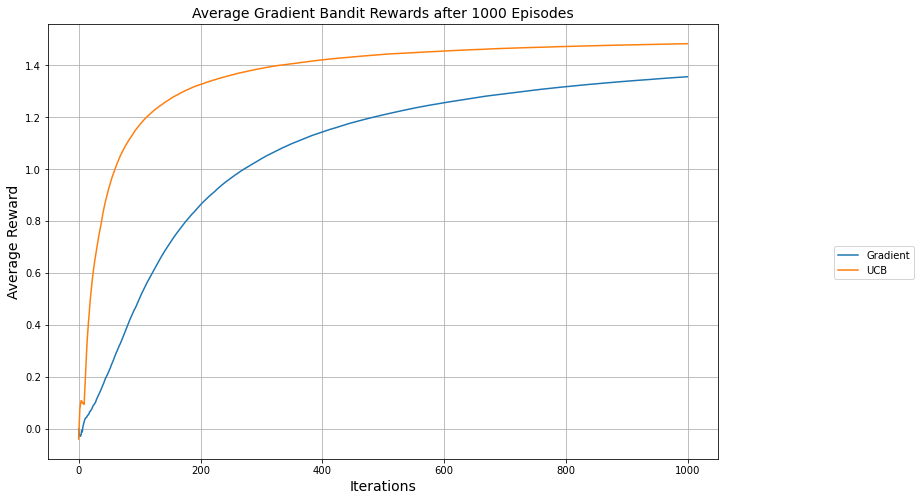

In [18]:
plt.figure(figsize=(12,8))
plt.plot(grad_rewards, label="Gradient")
plt.plot(ucb_rewards, label="UCB")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Average Reward", fontsize=14)
plt.title("Average Gradient Bandit Rewards after " + str(episodes) + " Episodes", fontsize=14)
plt.grid()
plt.show()

모든 iteration에서 UCB가 Gradient Bandits보다 더 나은 성능을 보이지만, iteration이 더 많이 반복될수록 Gradient Bandits이 학습한 후 훨씬 더 우수하고 일관성있게 성능을 발휘할 것으로 짐작할 수 있다

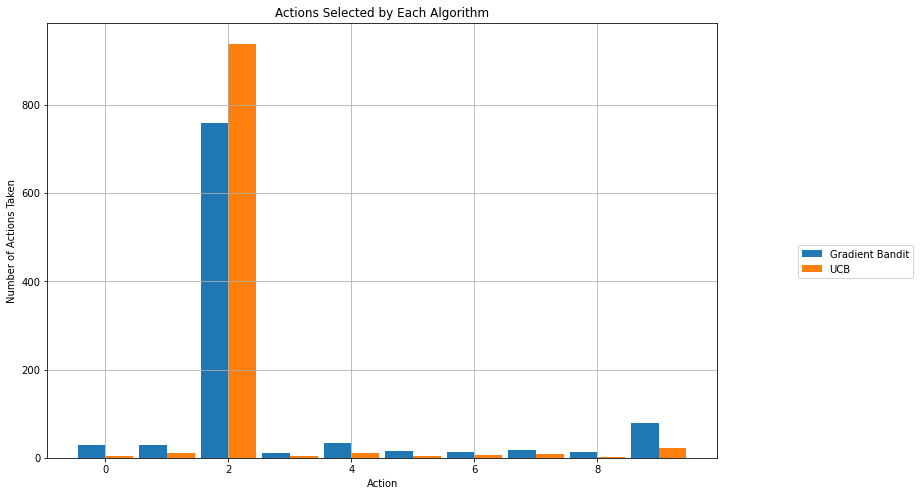

Percentage of actions selected:


,a = 0,a = 1,a = 2,a = 3,a = 4,a = 5,a = 6,a = 7,a = 8,a = 9
Grad,3.00,2.80,75.80,1.10,3.40,1.50,1.40,1.80,1.40,7.80
UCB,0.50,1.20,93.90,0.30,1.00,0.30,0.60,0.80,0.20,2.20
Expected Reward,0.66,0.55,1.34,-1.42,0.98,-0.52,0.18,0.27,-1.04,1.03


In [19]:
import pandas as pd
width = 0.45
bins = np.linspace(0, k-1, k) - width/2

plt.figure(figsize=(12,8))
plt.bar(bins, grad.k_n,
        width=width, 
        label="Gradient Bandit")
plt.bar(bins+0.45, ucb.k_n,
        width=width, 
        label="UCB")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.title("Actions Selected by Each Algorithm")
plt.xlabel("Action")
plt.ylabel("Number of Actions Taken")
plt.grid()
plt.show()

opt_per = np.array([grad.k_n, ucb.k_n]) / iters * 100
df = pd.DataFrame(np.vstack([opt_per, 
    grad.mu.reshape(-1, 1).T.round(2)]), 
    index=["Grad", "UCB", "Expected Reward"],
    columns=["a = " + str(x) for x in range(0, k)])
print("Percentage of actions selected:")
df